<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Image-Classifiers---Part-One" data-toc-modified-id="Image-Classifiers---Part-One-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Image Classifiers - Part One</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Dataset" data-toc-modified-id="Dataset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Dataset</a></span></li><li><span><a href="#Methodology" data-toc-modified-id="Methodology-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Methodology</a></span></li><li><span><a href="#Model-Setup" data-toc-modified-id="Model-Setup-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Model Setup</a></span></li><li><span><a href="#Model-Implementation" data-toc-modified-id="Model-Implementation-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Model Implementation</a></span></li><li><span><a href="#Results-Discussion" data-toc-modified-id="Results-Discussion-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Results Discussion</a></span><ul class="toc-item"><li><span><a href="#Variance-and-bias" data-toc-modified-id="Variance-and-bias-1.6.1"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>Variance and bias</a></span></li><li><span><a href="#Inspect-incorrect-classifications" data-toc-modified-id="Inspect-incorrect-classifications-1.6.2"><span class="toc-item-num">1.6.2&nbsp;&nbsp;</span>Inspect incorrect classifications</a></span></li><li><span><a href="#Evaluation-metric" data-toc-modified-id="Evaluation-metric-1.6.3"><span class="toc-item-num">1.6.3&nbsp;&nbsp;</span>Evaluation metric</a></span></li></ul></li><li><span><a href="#Further-modeling" data-toc-modified-id="Further-modeling-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>Further modeling</a></span><ul class="toc-item"><li><span><a href="#Variable-learning-rates" data-toc-modified-id="Variable-learning-rates-1.7.1"><span class="toc-item-num">1.7.1&nbsp;&nbsp;</span>Variable learning rates</a></span></li><li><span><a href="#Altering-the-image-size" data-toc-modified-id="Altering-the-image-size-1.7.2"><span class="toc-item-num">1.7.2&nbsp;&nbsp;</span>Altering the image size</a></span></li></ul></li></ul></li></ul></div>

<h1 style="text-align: center;">Image Classifiers - Part One</h1>

## Introduction

<img style="float: left; margin-right: 15px;" src="images/catMonocle.jpg" />

The overall goal of this series of write-ups is to explore a number of models performing binary classification on images.  As this is the first write-up in the series we'll start off with one of the simplest models:  Logistic regression with gradient descent.  

The goal of the model created in this write-up will be to peform binary classification on a set of images, and output a set of predictions as to whether or not each of those images is a cat or not (hence the binary nature of the model).  We covered the logistics of aquiring and developing an image dataset in a [previous write-up](https://github.com/nrasch/Portfolio/tree/master/Machine-Learning/Python/P02-Image-Dataset-Creation-Feb-2018), so we'll assume that dataset is avaiable and being utilized for this project.

So, let's get started!

## Dataset

In a previous write-up we dealt with the tasks involved in creating an image dataset of labeled cat and non-cat pictures.  This write-up will utilize the output of those efforts.  In the `datasets` directory we have an HDF5 archive containing the image data for the model we'll build below.  We can go ahead and examine the contents of the archive:

In [1]:
%matplotlib inline

# autoreload reloads modules automatically before entering the execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

from os import path
from utils import *
import pandas as pd
import numpy as np

dim = 128

*** KEYS
HDF5 container keys: ['testData', 'testLabels', 'trainData', 'trainLabels']

*** LABELS
Total number of training labels: 800
Number of cat labels: 395
Number of object labels: 405
First 10 training labels: [1 1 0 1 1 1 1 1 1]


Total number of testing labels: 200
Number of cat labels: 105
Number of object labels: 95
First 10 testing labels: [0 1 0 1 1 1 1 1 0]


*** IMAGE DATA
Image data shape in archive: (800, 128, 128, 3)


First HDF5 container dataSet item shape: (128, 128, 3)
Image data shape after flattening: (384, 128)
First 10 dataSet item matrix values: [128 119  95 130 118  89  99 125  87 117]


Recreating and showing first 20 images from flattened matrix values:



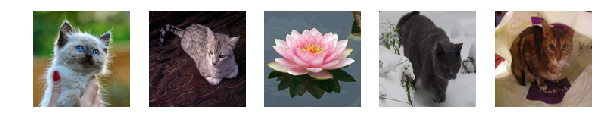

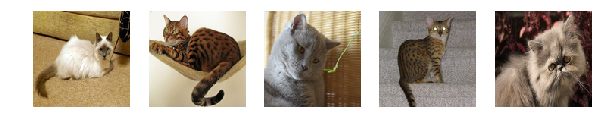

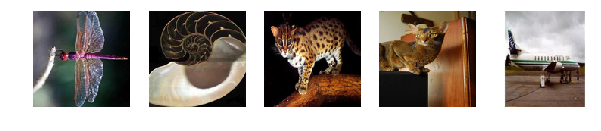

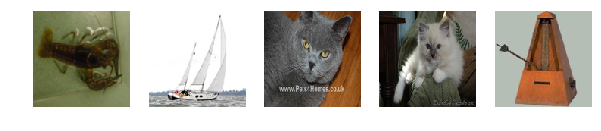

In [2]:
imageData = path.join("datasets", "miniCat500.hdf5")
         
validateArchive(imageData)

Let's also go ahead and assign the contents of the image dataset archive to variables for use later on:

In [3]:
with h5py.File(imageData, "r") as archive:   
    trainingData = np.squeeze(archive["trainData"][:])
    testData = np.squeeze(archive["testData"][:])
    trainingLabels = np.array(archive["trainLabels"][:])
    testLabels = np.array(archive["testLabels"][:])
    archive.close()

print("Archive trainingData.shape:    ", trainingData.shape)
print("Archive trainingLabels.shape:  ", trainingLabels.shape)
print("Archive testData.shape:        ", testData.shape)
print("Archive testLabels.shape:      ", testLabels.shape)
print("\n")

# Reshape the training and test data and label matrices
trainingData = trainingData.reshape(trainingData.shape[0], -1).T
testData = testData.reshape(testData.shape[0], -1).T

print ("Flattened, normalized trainingData shape:  " + str(trainingData.shape))
print ("Flattened, normalized testData shape:      " + str(testData.shape))

trainingData = trainingData/255.
testData = testData/255.

Archive trainingData.shape:     (800, 128, 128, 3)
Archive trainingLabels.shape:   (1, 800)
Archive testData.shape:         (200, 128, 128, 3)
Archive testLabels.shape:       (1, 200)


Flattened, normalized trainingData shape:  (49152, 800)
Flattened, normalized testData shape:      (49152, 200)


With that accomplished we can move on to the methodology and implementation of the logistic regression model utilizing gradient descent.

## Methodology

<img src="images/cat_classifier_single_image.png" />

The image above provides a high-level overview of the process we'll use to build the classifier in this write-up.  First we start by collecting some number of labeled images.  Next, we convert each image into a set of three matrices:  One for the color intensity of red values in the image's pixels, one for the blue intensity values, and one for the green intensity values.

(This set of intensity values for red, blue and green is referred to as the _RGB color sytem_.)

> RGB color space or RGB color system, constructs all the colors from the combination of the Red, Green and Blue colors.

> The red, green and blue use 8 bits each, which have integer values from 0 to 255. This makes 256*256*256=16777216 possible colors.

> RGB ≡ Red, Green, Blue

> Each pixel in the LED monitor displays colors this way, by combination of red, green and blue LEDs (light emitting diodes).

> When the red pixel is set to 0, the LED is turned off. When the red pixel is set to 255, the LED is turned fully on.

> Any value between them sets the LED to partial light emission.  (<a href="https://www.rapidtables.com/web/color/RGB_Color.html">www.rapidtables.com</a>)

The RGB value matrices are then flattened into an array of shape __(n,1)__ where __n__ is the total number of pixels in the image.  So for example an image that is 64 pixels square would consist of $64 \text{ pixels}*64 \text{ pixels}*3 \text{ RGB channels} = 12288 \text{ pixels}$.

The three flattened RGB value matrices are then stacked on top of one another to form a single feature matrix for the image in question.  Once this is done for the entire dataset worth of images we end up with a matrix of shape __(NumberOfPixels, NumberOfImages)__.  So for a dataset of 100 images that are 64 pixels square the final matrix would have shape __(12288,100)__.

This matrix is then fed into the logistic regression model which after training with gradient descent will output predictions on whether or not a given image is a cat.  And, maybe if we're lucky, it will be accurate too.  ;)

## Model Setup

We are going to build a logistic regression model and then train it with gradient descent in order to recognize cats.  It will look something like this:

<img src="images/logistic_regression_image_classifier_model.png" align="left" height="60%" width="60%" padding-left="100px" />
<p style="clear: both;">&nbsp;</p>

As you can see we don't have any hidden layers.  We simply feed the values of the image feature matrix directly into the output layer.  The output layer applies logstic regression to the features via the formula: 

\begin{equation}
z^{(i)} = w^T x^{(i)} + b
\end{equation}

The value of $z^{(i)}$ is then fed into an activation function:  

\begin{equation}
a^{(i)} = sigma(z^{(i)})
\end{equation}

The activation function (i.e. sigma) that we'll utilize will be the sigmoid function:

<img src="images/sigmoid.png" align="left" height="300px" width="300px" padding-left="100px" />
<p style="clear: both;">&nbsp;</p>

The sigmoid function outputs a probability value, $\hat{y}^{(i)}$, that is guaranteed to be between zero and one (note the upper and lower bounds on the x-axis).  

Probabilities where $\hat{y}^{(i)} = a^{(i)} > 0.5$ are labeled with a value of 1 (i.e. $\longrightarrow \ y^{(i)} \epsilon\ [{cat images}]$).  Probabilities where $\hat{y}^{(i)} = a^{(i)} <= 0.5$ are labeled with a value of 0 (i.e. $\longrightarrow \ y^{(i)} \neq \epsilon\ [{cat images}]$).


We can then compare what the model outputs vs. the actual labels of the images in order to obtain an error rate (or _cost_ of the model) using the following formula:  

$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{3}$$

where

$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{4}$$

From here we walk backward (i.e. backpropagation) through the model and find out how much each value of w and b added to the overall error rate.  This is done by taking the derivative of _w_ and _b_ utilizing the following formulas:

$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{5}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{6}$$

This allows us to _minimize_ the influence of those values that added to the model's __incorrect__ prediction rate, and _maximize_ the influence of those values that added to the model's __correct__ prediction rate.   This is done by updating the weights of _w_ and _b_ based on the derivative values with the following formulas:

$$w = w - \alpha({\partial w})\tag{7}$$ 

$$b = b - \alpha({\partial b})\tag{8}$$

where $\alpha$ is the learning rate.

We then do this over and over some number of times, and as we progress the weights on the values that help the model make correct decisions are made greater and greater.  Then hopefully at the end we have classifier that has been well trained and can detect whether or not an image is a cat.  

So now let's get to the coding, which of course is the fun part!

## Model Implementation

* Import the libraries we'll need:

In [4]:
from matplotlib import pyplot as plt
import numpy as np
import inspect
import time

import random 
random.seed(10)

* Create the classes for the activation functions.  This is more than what we need for this simple write-up, but later on we can dynamically pass these into future models.

In [5]:


class AbstractActivation(object):
    def activate(self, z):
        raise NotImplementedError("Requires implementation by inheriting class.")
        
class Sigmoid(AbstractActivation):
    def activate(self, z):
        return 1 / (1 + np.exp(-(z)))
        
class Relu(AbstractActivation):
    def activate(self, z):
        return  z * (z > 0)

* Create the logstic regression classification model

In [18]:
# Logistic regression classification model utilizing gradient descent
class LRImageClassifier:
    
    # Initialize class
    def __init__(self, trainingData, trainingLabels, testData, testLabels, learningRate = .005, iterations = 2000, activation = Sigmoid(), printOutput = True):
        self.learningRate = learningRate
        self.iterations = iterations
        self.activation = activation
        self.trainingData = trainingData
        self.trainingLabels = trainingLabels
        self.testData = testData
        self.testLabels = testLabels
        self.printOutput = printOutput
        
        self.w = np.zeros(())
        self.b = 0
        self.dw = np.zeros(())
        self.db = 0
        self.costs = []
        self.trainingPredict = np.zeros(()) 
        self.testPredict = np.zeros(())
        
    # Print out a summary of the model's attributes and their values
    def summary(self):
        for key in self.__dict__:
            print("Key: " + key)
            print("Value: ")
            print(getattr(self, key))
            print("\n")
        
    # Populate the initial values of the weight containers
    def intialize(self):
        # Remember:  Generally w^[l] = (n^[l], n^[l-1])
        # Since we have no hidden layers we go straight from n features to the output
        #self.w = np.random.randn(self.trainingData.shape[0], 1) * .0001
        self.w = np.zeros((self.trainingData.shape[0], 1))
        self.b = 0
        
    # Compute the cost of the function
    def cost(self, m, a, y):
        cost = (-1/m) * np.sum( y*np.log(a) + (1-y)*np.log(1-a) )
        
        #print(m)
        #print(a.shape)
        #print(a[1:10])
        #print(y)
        return cost
    
    # Perform forward and backward propagation
    def propagate(self):
        # Forward prop:
        samples = self.trainingData.shape[1]
        
        z = np.add(np.dot(self.w.T, self.trainingData), self.b)
        a = self.activation.activate(z)
        #print(z)
        #print(a)
        cost = self.cost(samples, a, self.trainingLabels)
        
        # Backward prop:
        self.dw = (1/samples) * np.dot(self.trainingData, (a-self.trainingLabels).T)
        self.db = (1/samples) * np.sum(a - self.trainingLabels)
        
        return cost
    
    # Update the model's weights utilizing the derivitives and the learning rate
    def updateWeights(self):
        self.w = self.w - self.learningRate * self.dw
        self.b = self.b - self.learningRate * self.db
        
        return
    
    # Given a set of features and weights output a classifiction prediction
    def predict(self, features):
        predictions = np.zeros((1, features.shape[1]))
        
        z = np.add(np.dot(self.w.T, features), self.b)
        a = self.activation.activate(z)
        
        for i in range(a.shape[1]):
            predictions[0, i] = 1 if a[0,i] > 0.5 else 0
            
        return predictions
        
    # Utilize gradient descent to train the logistic regression model and output the results against the test set
    def classify(self):
        start_time = time.time()
        
        self.intialize()
        
        # Train the model utilizing gradient descent
        for i in range(self.iterations+1):
            cost = self.propagate()
            self.updateWeights()
            if i % 500 == 0 and self.printOutput:
                print("Cost for iteration " + str(i) + ": " + str(cost))
            if i % 100 == 0:
                self.costs.append(cost)
        
        # Make predictions
        self.trainingPredict = self.predict(self.trainingData)
        #print(self.trainingPredict)
        self.testPredict = self.predict(self.testData)
        #print(self.testPredict)
        
        # Output time taken for execution
        if self.printOutput:
            print("\n--- Execution time:  %s seconds ---" % round(time.time() - start_time, 2))
        
        # Output error rate
        trainAccuracy = 100 - np.mean(np.abs(self.trainingPredict - self.trainingLabels)) * 100
        testAccuracy = 100 - np.mean(np.abs(self.testPredict - self.testLabels)) * 100
        
        return trainAccuracy, testAccuracy

* Let's try it out!


*** Starting!
Cost for iteration 0: 0.6931471805599452
Cost for iteration 500: 0.5442930916277906
Cost for iteration 1000: 0.4971599313812854
Cost for iteration 1500: 0.4624150145938873
Cost for iteration 2000: 0.4341320671765304
Cost for iteration 2500: 0.41013722125460866
Cost for iteration 3000: 0.3892866038092728
Cost for iteration 3500: 0.37086852988398844
Cost for iteration 4000: 0.3543987517859185
Cost for iteration 4500: 0.33952887219124506
Cost for iteration 5000: 0.3259982898356108

--- Execution time:  327.97 seconds ---
*** Done!


Train accuracy: 91.125
Test accuracy: 61.5


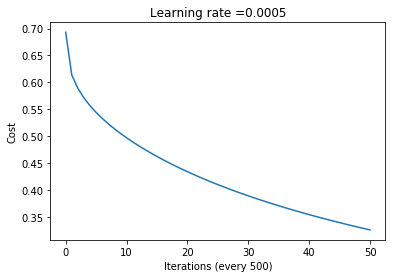

In [7]:
print("\n*** Starting!")
model = LRImageClassifier(trainingData, trainingLabels, testData, testLabels, learningRate = .0005, iterations = 5000)
trainAccuracy, testAccuracy = model.classify()
print("*** Done!\n")

print("\nTrain accuracy:", trainAccuracy)
print("Test accuracy:", testAccuracy)

costs = np.squeeze(model.costs)
plt.plot(costs)
plt.ylabel('Cost')
plt.xlabel('Iterations (every 500)')
plt.title("Learning rate =" + str(model.learningRate))
plt.show()

## Results Discussion

### Variance and bias

With such a large difference between the train and test set error rates (91.1% vs. 61.5%) it's clear we have a variance problem (i.e. we are overfitting on the training data and not generalizing well on the unseen data contained in the test set).  

In order to mitigate the high variance we could for example also take one or more of the following actions:
* Add more training data
* Introduce regularization to the model
* Fine tune the model's hyperparameters
* Modify the model's architecture by adding something like dropout regularization (but obviously this would need to be a proper nueral network)

Seeing as how this model is rather basic we'll skip any major tuning for the moment, and save our energy for more sophisticated models in other write-ups.  However, having said that, we will take a moment to examine what happens if we modify the learning rate and number of model training iterations:

### Inspect incorrect classifications

Sometimes it is also helpful when doing error analysis to inspect some of the incorrectly classified items as this can provide further insights:

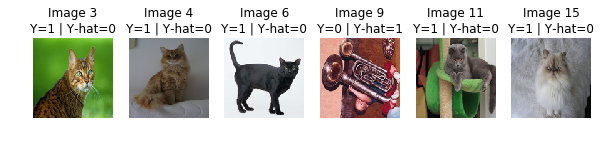

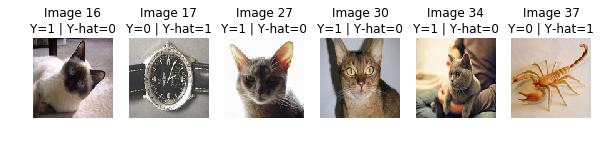

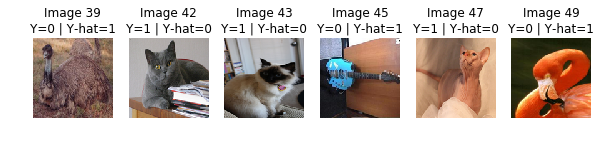

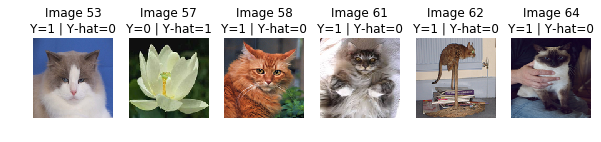

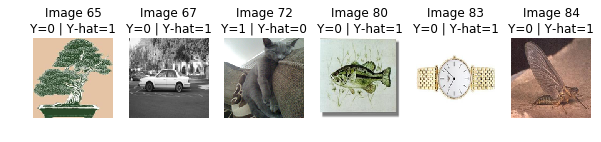

In [8]:
# Squeeze the predictions down into an array
y = np.squeeze(model.testLabels) 
yhat = np.squeeze(model.testPredict.astype(int))

# Which predictions were incorrect?
oops = y != yhat

# Get the index locations of any True values, so we know which image to examine from the test dataset
indices = np.squeeze(np.nonzero(oops))

# Display the images incorrectly classified along with true (y) and predicted (y-hat) labels
images = []
labels = []
for index in indices:    
    images.append(model.testData[:,index].reshape((dim, dim, 3)))
    labels.append("Image " + str(index) + "\nY=" + str(y[index]) + " | Y-hat=" + str(yhat[index]))
    if len(labels) == 30:
        break
 
grid_display(images, labels, 6, (10,10))    


Some of the misclassifications make sense, and other perhaps not so much...

### Evaluation metric
Lastly, we can also compute the F1 score as an evaluation metric for the model we trained, so that we can compare it to other models developed later on:

In [9]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, fscore, support = score(np.squeeze(model.testLabels), np.squeeze(model.testPredict))

print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F-Score: {}'.format(fscore))

Precision: [0.58490566 0.64893617]
Recall: [0.65263158 0.58095238]
F-Score: [0.61691542 0.61306533]


## Further modeling

### Variable learning rates

In [10]:
def runModels(iterations, learningRateRange):
    accuracy = { "trainingAccuracy": [], "testingAccuracy": [], "learningRate": []}

    print("\n*** Starting!")
    for i in learningRateRange:
        learningRate = round(i * .0001, 4)

        print("Running model for learning rate", learningRate, "over", iterations, "iterations")

        accuracy["learningRate"].append(i * .0001)
        trainAccuracy, testAccuracy = LRImageClassifier(
            trainingData, trainingLabels, testData, testLabels, 
            learningRate, iterations, printOutput = False).classify()

        accuracy["trainingAccuracy"].append(trainAccuracy)
        accuracy["testingAccuracy"].append(testAccuracy)

    print("*** Done!\n")

    plt.plot(accuracy["learningRate"], accuracy["trainingAccuracy"], 'g', accuracy["learningRate"], accuracy["testingAccuracy"], 'r')
    plt.ylabel('Train/Test Accuracy %')
    plt.xlabel('Learning Rate')
    plt.title("Train/Test Accuracy vs. Learning Rate at 5,000 Iterations")
    plt.legend(("Training Accuracy", "Testing Accuracy"))
    plt.show

    df = pd.DataFrame([accuracy['trainingAccuracy'], accuracy['testingAccuracy']], 
                      columns = list(accuracy['learningRate']), 
                      index = ("Training", "Testing"))    
    print("\n")
    print(df)
    print("\n")
    
    return


*** Starting!
Running model for learning rate 0.0001 over 5000 iterations
Running model for learning rate 0.0002 over 5000 iterations
Running model for learning rate 0.0003 over 5000 iterations
Running model for learning rate 0.0004 over 5000 iterations
Running model for learning rate 0.0005 over 5000 iterations
Running model for learning rate 0.0006 over 5000 iterations
Running model for learning rate 0.0007 over 5000 iterations
Running model for learning rate 0.0008 over 5000 iterations
*** Done!



           0.001  0.002   0.003  0.004   0.005  0.006   0.007   0.008
Training  77.875   83.5  87.625   90.0  91.125  92.75  94.125  94.625
Testing   60.500   60.0  62.000   62.5  61.500  62.00  62.000  61.500




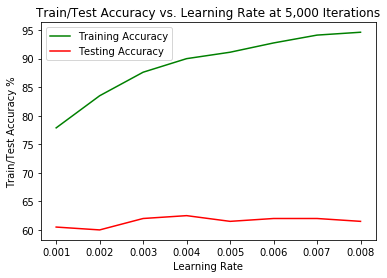

In [51]:
runModels(5000, range(1,9))

Frankly not that impressive, and hopefully we'll get some better results with more sophisticated models later on.  It appears from our observations that the best learning rate for the 5,000 training iteration model is 0.0004.  It seems to provide the best balance between the training and testing accuracy rates.

### Altering the image size

Let's also run through the models again with a smaller image size of 64 x 64 pixels instead of 128 x 128:

*** KEYS
HDF5 container keys: ['testData', 'testLabels', 'trainData', 'trainLabels']

*** LABELS
Total number of training labels: 800
Number of cat labels: 396
Number of object labels: 404
First 10 training labels: [0 0 1 1 1 1 1 1 0]


Total number of testing labels: 200
Number of cat labels: 104
Number of object labels: 96
First 10 testing labels: [1 1 0 0 1 1 0 0 0]


*** IMAGE DATA
Image data shape in archive: (800, 64, 64, 3)


First HDF5 container dataSet item shape: (64, 64, 3)
Image data shape after flattening: (192, 64)
First 10 dataSet item matrix values: []


Recreating and showing first 20 images from flattened matrix values:



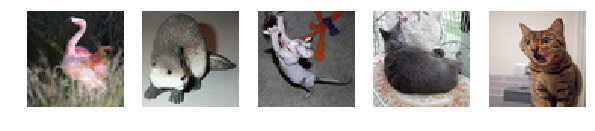

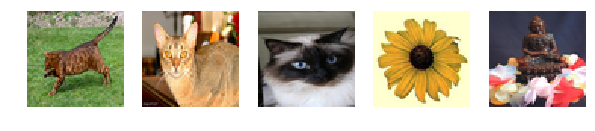

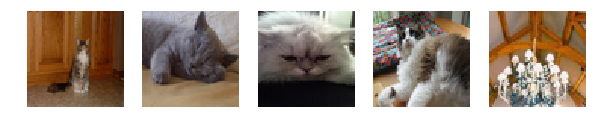

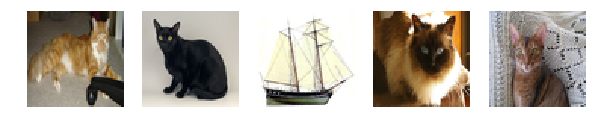

In [15]:
settings["resizeDim"] = 64
imageData = path.join("datasets", "imageData500_64pixels.hdf5")
         
validateArchive(imageData)

Archive trainingData.shape:     (800, 64, 64, 3)
Archive trainingLabels.shape:   (1, 800)
Archive testData.shape:         (200, 64, 64, 3)
Archive testLabels.shape:       (1, 200)


Flattened, normalized trainingData shape:  (12288, 800)
Flattened, normalized testData shape:      (12288, 200)

*** Starting!
Cost for iteration 0: 0.6931471805599452
Cost for iteration 500: 0.6069633661833443
Cost for iteration 1000: 0.5767259228143984
Cost for iteration 1500: 0.5561070935677571
Cost for iteration 2000: 0.5398106049466759
Cost for iteration 2500: 0.5260176337261937
Cost for iteration 3000: 0.5138884457372493
Cost for iteration 3500: 0.5029660027966562
Cost for iteration 4000: 0.49297325702734895
Cost for iteration 4500: 0.48372868903799005
Cost for iteration 5000: 0.47510601172673333

--- Execution time:  68.49 seconds ---
*** Done!


Train accuracy: 80.0
Test accuracy: 63.0


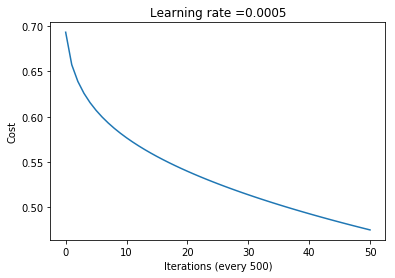

In [16]:
with h5py.File(imageData, "r") as archive:   
    trainingData = np.squeeze(archive["trainData"][:])
    testData = np.squeeze(archive["testData"][:])
    trainingLabels = np.array(archive["trainLabels"][:])
    testLabels = np.array(archive["testLabels"][:])
    archive.close()

print("Archive trainingData.shape:    ", trainingData.shape)
print("Archive trainingLabels.shape:  ", trainingLabels.shape)
print("Archive testData.shape:        ", testData.shape)
print("Archive testLabels.shape:      ", testLabels.shape)
print("\n")

# Reshape the training and test data and label matrices
trainingData = trainingData.reshape(trainingData.shape[0], -1).T
testData = testData.reshape(testData.shape[0], -1).T

print ("Flattened, normalized trainingData shape:  " + str(trainingData.shape))
print ("Flattened, normalized testData shape:      " + str(testData.shape))

trainingData = trainingData/255.
testData = testData/255.

print("\n*** Starting!")
model = LRImageClassifier(trainingData, trainingLabels, testData, testLabels, learningRate = .0005, iterations = 5000)
trainAccuracy, testAccuracy = model.classify()
print("*** Done!\n")

print("\nTrain accuracy:", trainAccuracy)
print("Test accuracy:", testAccuracy)

costs = np.squeeze(model.costs)
plt.plot(costs)
plt.ylabel('Cost')
plt.xlabel('Iterations (every 500)')
plt.title("Learning rate =" + str(model.learningRate))
plt.show()

For the larger image size we obtained:
* Train accuracy: 91.125
* Test accuracy: 61.5

So it appears we did somewhat better with smaller images (+1.5% test accuracy).  This is likely attributed to the model being less able to over fit against the smaller images with less pixels.  Let's try the variable learning rate excise with the smaller images too: 


*** Starting!
Running model for learning rate 0.0001 over 5000 iterations
Running model for learning rate 0.0002 over 5000 iterations
Running model for learning rate 0.0003 over 5000 iterations
Running model for learning rate 0.0004 over 5000 iterations
Running model for learning rate 0.0005 over 5000 iterations
Running model for learning rate 0.0006 over 5000 iterations
Running model for learning rate 0.0007 over 5000 iterations
Running model for learning rate 0.0008 over 5000 iterations
*** Done!



          0.0001  0.0002  0.0003  0.0004  0.0005  0.0006  0.0007  0.0008
Training    70.5  73.375  76.375    78.0    80.0   81.25  81.625    83.0
Testing     64.0  65.500  65.000    64.5    63.0   63.00  63.000    63.0




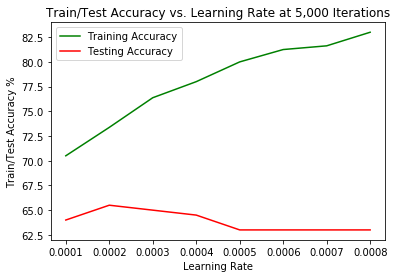

In [17]:
runModels(5000, range(1,9))

So we seem to have the best test set performance over 5,000 iterations with a learning rate of 0.0002 for a 64 x 64 pixel image size.  This gives us a 3% accuracy increase over the best model for the 128 x 128 pixel images over 5,000 iterations with a learning rate of 0.0004.  

Summary table:

<table>
    <tr>
        <th>Image Size</th>
        <th>Iterations</th>
        <th>Learning Rate</th>
        <th>Test Set Accuracy</th>
    </tr>
    <tr>
        <td>128 x 128 pixels</td>
        <td>5,000</td>
        <td>0.0004</td>
        <td>62.5%</td>
    </tr>
    <tr>
        <td>64 x 64 pixels</td>
        <td>5,000</td>
        <td>0.0002</td>
        <td>65.5%</td>
    </tr>
</table>

And we'll wrap up with an evaluation metric for the 0.0002 learning rate model:

In [21]:
model = LRImageClassifier(trainingData, trainingLabels, testData, testLabels, learningRate = .0002, iterations = 5000, printOutput = False)
trainAccuracy, testAccuracy = model.classify()

print("\nTrain accuracy:", trainAccuracy)
print("Test accuracy:", testAccuracy)
print("\n")

precision, recall, fscore, support = score(np.squeeze(model.testLabels), np.squeeze(model.testPredict))
print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))
print('F-Score: {}'.format(fscore))


Train accuracy: 73.375
Test accuracy: 65.5


Precision: [0.63366337 0.67676768]
Recall: [0.66666667 0.64423077]
F-Score: [0.64974619 0.66009852]
